# [CDAF] Atividade 6

## Nome
Nome: Rodrigo Felipe Lima Braz


## Referências
- [1] https://www.ecmlpkdd2019.org/downloads/paper/701.pdf
- [2] https://dtai.cs.kuleuven.be/sports/blog/player-vectors:-characterizing-soccer-players'-playing-style
- [3] https://dtai.cs.kuleuven.be/sports/player_vectors
- [4] https://github.com/TomDecroos/matplotsoccer

## Introdução
- Nessa atividade, temos implementado o "Player Vectors", método proposto em [1] para caracterizar o estilo de jogo de jogadores baseado nas localizações que realizam cada tipo de ação.
- [2] apresenta o conteúdo do paper em [1] de forma mais resumida e visual, em formato de blog.
- [3] oferece uma demo interativa com uma aplicação do método no contexto de comparar a similaridade entre jogadores.
- [4] é uma biblioteca para plotar visualizações de partidas de futebol. Além disso, ela tem uma função pronta para criar heatmaps de ações de jogadores, que é util para o nosso contexto.

## Intruções
- Para cada header abaixo do notebook, vocês devem explicar o que foi feito e à qual seção/subseção/equação de [1] ela corresponde. Justifique suas respostas.
- Além disso, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do Player Vectors abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

### Carregando os dados

In [27]:
import numpy as np
import pandas as pd

In [28]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        team_match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        team_match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(team_match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return matches, team_matches

In [29]:
def get_position(x):
    return x['name']

def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players['role'] = players['role'].apply(get_position)
    players = players[['wyId', 'player_name', 'role']].rename(columns={'wyId': 'player_id'})

    return players

In [30]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [31]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [32]:
leagues = ['England', 'Spain']
events = {}
matches = {}
team_matches = {}
game_minutes = {}
for league in leagues:
    path = r"C:\Users\rodri\Desktop\Atividades\Ciencia_de_dados_futebol\atv6\matches_{}.json".format(league)
    matches[league], team_matches[league] = load_matches(path)
    path = r"C:\Users\rodri\Desktop\Atividades\Ciencia_de_dados_futebol\atv6\events_{}.json".format(league)
    events[league] = load_events(path)
    path = r"C:\Users\rodri\Desktop\Atividades\Ciencia_de_dados_futebol\atv6\minutes_played_per_game_{}.json".format(league)
    game_minutes[league] = load_minutes_played_per_game(path)

In [33]:
path = r"C:\Users\rodri\Desktop\Atividades\Ciencia_de_dados_futebol\atv6\players.json"
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

In [34]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

Esse header basicamente foi processamento e tratativa de dados, para facilitar a aplicação das ferramentas posteriores.

### SPADL

In [35]:
from tqdm import tqdm
import socceraction.spadl as spd

In [36]:
def spadl_transform(events, team_matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [37]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], team_matches=team_matches[league])

100%|██████████| 380/380 [02:03<00:00,  3.08it/s]


Esse header, foi para transformar os dados no padrão SPADL.

### Construção de Heatmaps

In [38]:
import scipy
import matplotsoccer as mps

In [39]:
def construct_heatmaps(spadl, season_minutes, action_type):
    heatmaps = {}
    if action_type == 'pass':
        heatmaps['start'] = {}
        heatmaps['end'] = {}
    for player_id in tqdm(season_minutes['player_id'].tolist()):
        mask = (spadl['player_id'] == player_id) & (spadl['type_name'] == action_type)
        player_actions = spadl[mask]
        if action_type != 'pass':
            heatmaps[player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps[player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps[player_id] = scipy.ndimage.gaussian_filter(heatmaps[player_id], 1)
        else:
            heatmaps['start'][player_id] = mps.count(x=player_actions['start_x'], y=player_actions['start_y'], n=25, m=16)
            heatmaps['start'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['start'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['start'][player_id], 1)
            heatmaps['end'][player_id] = mps.count(x=player_actions['end_x'], y=player_actions['end_y'], n=25, m=16)
            heatmaps['end'][player_id] *= (90 / season_minutes[season_minutes['player_id'] == player_id]['minutes_played'].values[0])
            heatmaps['end'][player_id] = scipy.ndimage.gaussian_filter(heatmaps['end'][player_id], 1)

    return heatmaps

In [40]:
season_minutes = {}
for league in leagues:
    season_minutes[league] = calculate_minutes_per_season(minutes_per_game=game_minutes[league])
    mask = (season_minutes[league]['minutes_played'] >= 900) & (season_minutes[league]['player_id'].isin(players.loc[players['role'] != 'Goalkeeper', 'player_id']))
    season_minutes[league] = season_minutes[league][mask]

In [41]:
action_types = ['shot', 'pass', 'cross', 'dribble']
heatmaps = {}
for league in leagues:
    heatmaps[league] = {}
    for at in action_types:
        heatmaps[league][at] = construct_heatmaps(spadl=spadl[league], season_minutes=season_minutes[league], action_type=at)

100%|██████████| 324/324 [00:06<00:00, 52.90it/s]


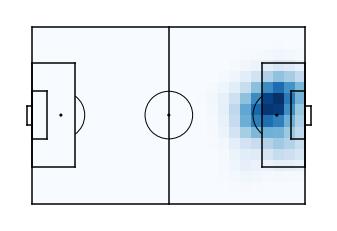

<AxesSubplot:>

In [42]:
mps.heatmap(heatmaps['Spain']['shot'][3359])

- [4] é uma biblioteca para plotar visualizações de partidas de futebol. Além disso, ela tem uma função pronta para criar heatmaps de ações de jogadores, que é util para o nosso contexto.

Acredito que seja esse passo, visto que, o objetivo desse header é criar uma vizualização dos heatmaps atravez da facilidade que a biblioteca traz.

### Comprimindo heatmaps para vetores

In [43]:
def heatmaps_to_vectors(heatmaps, action_type):
    if action_type != 'pass':
        vectorized_heatmaps = np.array([heatmaps[player_id].reshape(-1) for player_id in heatmaps.keys()])
    else:
        vectorized_heatmaps = np.array([np.concatenate([heatmaps['start'][player_id].reshape(-1), heatmaps['end'][player_id].reshape(-1)]) for player_id in heatmaps['start'].keys()])

    return vectorized_heatmaps

In [44]:
vectorized_heatmaps = {}
for league in leagues:
    vectorized_heatmaps[league] = {}
    for act_type in action_types:
        vectorized_heatmaps[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps[league][act_type], action_type=act_type)

Objetivo desse header é traduzir os dados dos heatmaps para vetores, para posteriormente calcular similaridade entre jogadores.

### NMF

In [45]:
from sklearn.decomposition import NMF

In [46]:
def nmf_decomposition(vectorized_heatmaps, n_components):
    nmf = NMF(n_components=n_components, init='nndsvda', random_state=0)
    nmf.fit(vectorized_heatmaps)

    return nmf

In [47]:
n_components = {'shot': 4, 'pass': 5, 'cross': 4, 'dribble': 5}
concat_vectors = {}
nmfs = {}
for act_type in action_types:
    concat_vectors[act_type] = np.concatenate([vectorized_heatmaps['England'][act_type], vectorized_heatmaps['Spain'][act_type]])
    nmfs[act_type] = nmf_decomposition(vectorized_heatmaps=concat_vectors[act_type], n_components=n_components[act_type])

Criação e treinamento de um modelo de Non-Negative Matrix Factorization, para tentar calcular padrões nos dados dos vetores, baseado principalmente em chute, passe, drible e cruzamento

### Reconstruction Evaluation

In [48]:
for act_type in action_types:
    print('{} Reconstruction evaluation\n'.format(act_type))
    print('Reconstruction error from NMF object: {}'.format(nmfs[act_type].reconstruction_err_))
    reconst_vectors = np.dot(nmfs[act_type].components_.T, nmfs[act_type].transform(concat_vectors[act_type]).T).T
    reconst_error = np.sqrt(np.sum((concat_vectors[act_type] - reconst_vectors) ** 2))
    print('Manual reconstruction error: {}'.format(reconst_error))
    print('Mean reconstruction error: {}'.format(reconst_error / (concat_vectors[act_type].shape[1])))
    print('--------------------------------\n')

shot Reconstruction evaluation

Reconstruction error from NMF object: 1.3224879226321518
Manual reconstruction error: 1.322487918480089
Mean reconstruction error: 0.0033062197962002225
--------------------------------

pass Reconstruction evaluation

Reconstruction error from NMF object: 28.196261893627764
Manual reconstruction error: 28.196261647153563
Mean reconstruction error: 0.035245327058941955
--------------------------------

cross Reconstruction evaluation

Reconstruction error from NMF object: 2.336538480019581
Manual reconstruction error: 2.336538445866538
Mean reconstruction error: 0.005841346114666345
--------------------------------

dribble Reconstruction evaluation

Reconstruction error from NMF object: 4.008096593968764
Manual reconstruction error: 4.008096580590021
Mean reconstruction error: 0.010020241451475051
--------------------------------



Esse header é basicamente avaliando a qualidade e desempenho do modelo treinado acima


### Deanonymization Evaluation

In [49]:
matches_1st = {}
matches_2nd = {}
spadl_1st = {}
spadl_2nd = {}
season_minutes_1st = {}
season_minutes_2nd = {}
for league in leagues:
    matches[league] = matches[league].sort_values(by='dateutc').reset_index(drop=True)
    matches_1st[league] = matches[league].loc[: int(len(matches[league]) / 2) - 1, 'wyId'].values.tolist()
    matches_2nd[league] = matches[league].loc[int(len(matches[league]) / 2) :, 'wyId'].values.tolist()
    season_minutes_1st[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_1st[league])])
    season_minutes_2nd[league] = calculate_minutes_per_season(game_minutes[league][game_minutes[league]['game_id'].isin(matches_2nd[league])])
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['minutes_played'] >= 900]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['minutes_played'] >= 900]
    season_minutes_1st[league] = season_minutes_1st[league][season_minutes_1st[league]['player_id'].isin(season_minutes_2nd[league]['player_id'])]
    season_minutes_2nd[league] = season_minutes_2nd[league][season_minutes_2nd[league]['player_id'].isin(season_minutes_1st[league]['player_id'])]
    mask_1st = (spadl[league]['game_id'].isin(matches_1st[league])) & (spadl[league]['player_id'].isin(season_minutes_1st[league]['player_id']))
    spadl_1st[league] = spadl[league][mask_1st]
    mask_2nd = (spadl[league]['game_id'].isin(matches_2nd[league])) & (spadl[league]['player_id'].isin(season_minutes_2nd[league]['player_id']))
    spadl_2nd[league] = spadl[league][mask_2nd]

In [50]:
heatmaps_1st = {}
heatmaps_2nd = {}
for league in leagues:
    heatmaps_1st[league] = {}
    heatmaps_2nd[league] = {}
    for at in action_types:
        heatmaps_1st[league][at] = construct_heatmaps(spadl=spadl_1st[league], season_minutes=season_minutes_1st[league], action_type=at)
        heatmaps_2nd[league][at] = construct_heatmaps(spadl=spadl_2nd[league], season_minutes=season_minutes_2nd[league], action_type=at)

100%|██████████| 154/154 [00:01<00:00, 149.48it/s]


In [51]:
vectorized_heatmaps_1st = {}
vectorized_heatmaps_2nd = {}
for league in leagues:
    vectorized_heatmaps_1st[league] = {}
    vectorized_heatmaps_2nd[league] = {}
    for act_type in action_types:
        vectorized_heatmaps_1st[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_1st[league][act_type], action_type=act_type)
        vectorized_heatmaps_2nd[league][act_type] = heatmaps_to_vectors(heatmaps=heatmaps_2nd[league][act_type], action_type=act_type)

In [52]:
def coefficients_transform(vectorized_heatmaps, nmf):
    return nmf.transform(vectorized_heatmaps)

In [53]:
vectorized_coefs_1st = {}
vectorized_coefs_2nd = {}
for league in leagues:
    vectorized_coefs_1st[league] = {}
    vectorized_coefs_2nd[league] = {}
    for act_type in action_types:
        vectorized_coefs_1st[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_1st[league][act_type], nmf=nmfs[act_type])
        vectorized_coefs_2nd[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps_2nd[league][act_type], nmf=nmfs[act_type])

In [54]:
player_vectors_1st = {}
player_vectors_2nd = {}
for league in leagues:
    player_vectors_1st[league] = np.concatenate([vectorized_coefs_1st[league][act_type] for act_type in action_types], axis=1)
    player_vectors_2nd[league] = np.concatenate([vectorized_coefs_2nd[league][act_type] for act_type in action_types], axis=1)

In [55]:
player_vectors_1st = np.concatenate([player_vectors_1st[league] for league in leagues])
player_vectors_2nd = np.concatenate([player_vectors_2nd[league] for league in leagues])

In [56]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps_1st[league]['shot'].keys())

In [57]:
from sklearn.metrics import pairwise_distances

In [58]:
D = pairwise_distances(player_vectors_1st, player_vectors_2nd, metric="manhattan")

# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

rs = np.argmax(np.array([p_i[i, :] == player_ids[i] for i in range(p_i.shape[0])]), axis=1)

def mean_reciprocal_rank(rs):
    return np.mean(1. / (rs + 1))

def top_k(rs, k):
    return (rs < k).sum() / len(rs)

mrr = mean_reciprocal_rank(rs)
top1 = top_k(rs, 1)
top3 = top_k(rs, 3)
top5 = top_k(rs, 5)
top10 = top_k(rs, 10)

In [59]:
print('Top 1 = {}%'.format(round(top1 * 100, 1)))
print('Top 3 = {}%'.format(round(top3 * 100, 1)))
print('Top 5 = {}%'.format(round(top5 * 100, 1)))
print('Top 10 = {}%'.format(round(top10 * 100, 1)))
print('MRR = {}'.format(round(mrr, 3)))

Top 1 = 38.3%
Top 3 = 61.4%
Top 5 = 70.5%
Top 10 = 81.9%
MRR = 0.532


- [2] apresenta o conteúdo do paper em [1] de forma mais resumida e visual, em formato de blog.

Acredito que seja essa a opção, visto que treinamos e avaliamos um modelo, que no final, nos da porcentagens e dados sobre as características treinadas e testadas.

### Explore Similar Players

In [60]:
vectorized_coefs = {}
for league in leagues:
    vectorized_coefs[league] = {}
    for act_type in action_types:
        vectorized_coefs[league][act_type] = coefficients_transform(vectorized_heatmaps=vectorized_heatmaps[league][act_type], nmf=nmfs[act_type])

In [61]:
player_vectors = {}
for league in leagues:
    player_vectors[league] = np.concatenate([vectorized_coefs[league][act_type] for act_type in action_types], axis=1)

In [62]:
player_vectors = np.concatenate([player_vectors[league] for league in leagues])

In [63]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps[league]['shot'].keys())

In [64]:
D = pairwise_distances(player_vectors, player_vectors, metric="manhattan")
# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

In [65]:
similar_players = pd.DataFrame(data=p_i[:, : 11], columns=['player_id'] + ['{}th_similar'.format(i) for i in range(1, 11)])

In [66]:
players = players[players['player_id'].isin(similar_players['player_id'])].reset_index(drop=True)

In [67]:
id_to_name = {}
for i in range(len(players)):
    id_to_name[players.loc[i, 'player_id']] = players.loc[i, 'player_name']

In [69]:
similar_players = similar_players.replace(id_to_name)
similar_players

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
0,Toby Alderweireld,Aïssa Mandi,David López Silva,Raphaël Varane,Gerard Piqué Bernabéu,Aritz Elustondo Irribaria,Unai Núñez Gestoso,Ezequiel Marcelo Garay,Jack Stephens,Facundo Sebastián Roncaglia,Daniele Bonera
1,Jan Vertonghen,Samuel Yves Umtiti,Zouhair Feddal,Íñigo Martínez Berridi,Wesley Hoedt,Clément Lenglet,Aymeric Laporte,Anaitz Arbilla Zabala,Pedro Bigas Rigo,Sergio Ramos García,Antonio Rüdiger
2,Christian Dannemann Eriksen,Mesut Özil,Kevin De Bruyne,Henrikh Mkhitaryan,Jesse Lingard,Francesc Fàbregas i Soler,Joan Jordán Moreno,Aaron Ramsey,Alex Pritchard,Pablo Fornals Malla,Paul Pogba
3,Ragnar Klavan,Andreu Fontàs Prat,Pedro Bigas Rigo,Thomas Vermaelen,Víctor Ruíz Torre,Sergio Ramos García,Alfie Mawson,Jeison Fabián Murillo Cerón,Clément Lenglet,Zouhair Feddal,Aymeric Laporte
4,Johann Berg Guðmunds­son,Matt Ritchie,Andros Townsend,David Remeseiro Salgueiro,Julián Omar Ramos Suárez,Michail Antonio,Theo Walcott,Ibai Gómez Pérez,Markel Susaeta Laskurain,Aaron Lennon,Sergio Gontán Gallardo
...,...,...,...,...,...,...,...,...,...,...,...
628,Roberto Suárez Pier,Ahmed Hegazy,Martín Maximiliano Mantovani,Bruno González Cabrera,Scott Dann,Rodrigo Ely,Alexis Ruano Delgado,James Tomkins,David Rodríguez Lombán,Ashley Williams,Claudio Ariel Yacob
629,Daniel Raba Antolí,Riyad Mahrez,Brais Méndez Portela,André Martín Carrillo Díaz,Carlos Soler Barragán,Xherdan Shaqiri,Anthony Knockaert,Ángel Martín Correa,Jordon Ibe,Sergio Gontán Gallardo,Andros Townsend
630,Oghenekaro Etebo,Harry Arter,Etienne Capoue,Mario Lemina,Álvaro Medrán Just,Jefferson Andrés Lerma Solís,Mikel Merino Zazón,Geoffrey Kondogbia,Igor Zubeldía Elorza,Andrew Surman,Idrissa Gana Gueye
631,Youssef En-Nesyri,Dwight Gayle,Munir El Haddadi Mohamed,Jonathan Calleri,Manolo Gabbiadini,José Salomón Rondón Giménez,Aritz Aduriz Zubeldia,Cenk Tosun,Carlos Arturo Bacca Ahumada,Troy Deeney,Jamie Vardy


- [3] oferece uma demo interativa com uma aplicação do método no contexto de comparar a similaridade entre jogadores.


Visto que, temos uma matriz onde podemos filtrar por qualquer player, e saber, de acordo com o modelo treinado com os vetores, qual jogadores mais se assemelham ao estilo deste player.


Fluxo: 

Carregamento e tratativa dos dados > Transformação no padrão SPALD > Criação dos Heatmaps> Compressão dos heatmaps em forma de vetores > Criação de um modelo para calcular similaridade em vetor> Avaliação e extração de métricas do modelo > Criação da matriz de comparação de estilos de jogadores para poder filtrar e trabalhar.